# Exercise 5
*CS-E5885 Modeling Biological Networks* <br>
*8th Feb, 2023* <br>

<hr>

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.linalg import expm
from scipy.optimize import least_squares
import matplotlib
import math

## 0. Data

`Y_data` contains 10 observations of the (normalized) expression level of 3 genes ($X_1$, $X_2$, $X_3$), at time points `t_data`. Each row is one observation and each column is one gene.

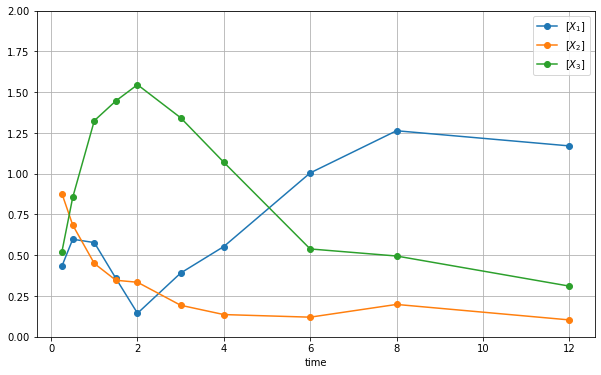

In [3]:
t_data = np.array([0.25, 0.5, 1, 1.5, 2, 3, 4, 6, 8, 12]) # time points
Y_data = np.array([
    [0.43363251, 0.87767177, 0.52257947],
    [0.59829549, 0.68515400, 0.85511583],
    [0.57771761, 0.44965359, 1.32524242],
    [0.35806804, 0.34666734, 1.44662417],
    [0.14424849, 0.33451828, 1.54588553],
    [0.39095813, 0.19332767, 1.34309046],
    [0.55361681, 0.13633700, 1.07001529],
    [1.00481754, 0.12037373, 0.53871530],
    [1.26352803, 0.19847235, 0.49535966],
    [1.17064081, 0.10360132, 0.31091261]])

plt.figure(figsize=(10,6))
plt.plot(t_data, Y_data, marker = "o")
plt.legend(('$[X_1]$', '$[X_2]$', '$[X_3]$'))
plt.xlabel('time')
plt.ylim(0,2)
plt.grid()
plt.show()

## 1. Alternative models

Again we use notation $\textbf{x}(t) = [x_1(t),\ x_2(t),\ x_3(t)]^{\top}$ where  $x_1 = [X_1]$, $x_2 = [X_2]$ and $x_3 = [X_3]$. The goal of the exercise is to try and infer which genes might be regulating which. This is done by comparing different alternative models. A model $M$ is represented by a $3 \times 3$ binary matrix, where for all $j,k = 1,2,3$,

*  If $M_{jk}$ is 1, then $X_k$ is somehow regulating $X_j$ 
*  If $M_{jk}$ is 0, then $X_k$ is not regulating $X_j$ 


We model the requlation as a linear differential equation

\begin{align*}
\frac{\text{d} \textbf{x}(t)}{\text{d} t} = A^M \textbf{x}(t) + \textbf{b}
\end{align*}

where $\textbf{b}= [b_1, b_2, b_3]^\top$ are the basal activation rates and $A^M$ is a 3 x 3 matrix in which the location of zero entries is specified by model $M$. Namely,

*  If $M_{jk}$ is 1, $A^M_{jk}$ is a regulation parameter, included in parameter vector $\theta_M$
*  If $M_{jk}$ is 0, $A^M_{jk}$ = 0

Additionally the basal rates $b_j$ are always included in the parameter vector $\theta_M$. 

**Example:** The full model where $M$ is a matrix of ones, length of $\theta_M$ is $3 \times 3 +3 = 12$

**Example:** In the empty model where $M$ is a matrix of ones, length of $\theta_M$ is $0 + 3 = 3$ 

Fill in the below function that given the model matrix $M$ and parameter vector $\theta_M$, returns the matrix $A_M$ and vector **b**. The order of the parameters in $\theta_M$ doesn't matter, as long as you are consistent in all remaining exercises.

In [4]:
def create_A_b(M, theta):
    """"Create matrix A and vector b.
    
    :param M: a binary numpy array with shape (3,3)
    :param theta: a list with lenght equal to 3 + number of ones in M
    :returns: A = numpy array with shape (3,3) and b = numpy array with shape (3,1).
    Data type of returned arrays must be float.
    """
    theta_A = theta[3:]
    A = np.zeros((3,3))
    b = theta[:3].reshape(3,1).astype('float64')
    
    # create A matrix
    counter = 0
    for i in range(3):
        for j in range(3):
            if M[i,j] == 1:
                A[i,j] = theta_A[counter]
                counter = counter + 1

    return A, b

Test your implementation in the cell below.

In [5]:
M = np.eye(3, dtype=int)
theta = np.array([1, 2, 3, 4, 5, 6])
A, b = create_A_b(M, theta)
print(f"A=\n{A}\n\nb=\n{b}\n")
print(A.dtype)
print(b.dtype)

A=
[[4. 0. 0.]
 [0. 5. 0.]
 [0. 0. 6.]]

b=
[[1.]
 [2.]
 [3.]]

float64
float64


## 2. Solving the system

Fill in the below function `solve_system` which outputs the solutions $\textbf{x}(t_i)$ for given model $M$, parameter vector $\theta_M$, and output time points $t_i$, given the initial value $\textbf{x}(0) = [0, 1, 0]^{\top}$. The models are linear ODEs so they have a closed form solution using the matrix exponential (`expm`) and you may utilize the given function `solve_linear_ode` below.

In [6]:
x_init = np.array([[0,1.0,0]]).T

# x_init, t_data, and Y_data are global variables which can be used inside
# functions and should not be overwritten by your code

def solve_linear_ode(A, b, t):
    """Solves the linear ODE, defined by matrix A and vector b, at time points t.
    
    :param A: a numpy array with shape (3,3)
    :param b: a numpy array with shape (3,1)
    :param t: a one-dimensional numpy array containing output time points t_i
    :returns: a numpy array with shape (len(t),3), containing solutions x(t_i) as rows
    """
    L = len(t)
    X_out = np.zeros((L, 3))
    x_star = np.linalg.solve(A, -b) # solve steady state x_star = - A^{-1} b
    for j in range(L):
        xj = x_star + expm(A*t[j])@(x_init - x_star)
        X_out[j,:] = xj.flatten()
    return(X_out)

def solve_system(M, theta, t):
    """"Solve dynamics of model M with parameters theta.
    
    :param M: a binary numpy array with shape (3,3)
    :param theta: a list with lenght equal to 3 + number of ones in M
    :param t: a one-dimensional numpy array containing output time points t_i
    :returns: a numpy array with shape (len(t),3), containing solutions x(t_i) as rows
    """
    A, b = create_A_b(M, theta)
    return solve_linear_ode(A, b, t)

Test your implementation in the cell below.

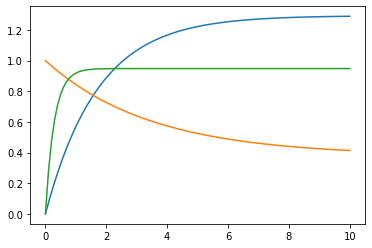

In [7]:
M = np.eye(3, dtype=int)
theta = np.array([0.75, 0.11, 3.28, -0.58, -0.29, -3.46])
t = np.linspace(0, 10, 101)
X_out = solve_system(M, theta, t)
plt.plot(t, X_out)
plt.show()

## 3. Likelihood

We assume that the initial values $\textbf{x}(0) = [0, 1, 0]^{\top}$ are known, but the $N$ observations in `Y_data` are noisy observations of $\textbf{x}(t)$ at the time points `t_data`. 

Let $\mu_{ij} = x_{j}(t_i \mid M, \theta_M)$ be the solution of the system defined by model $M$ and parameters $\theta_M$, for gene $X_j$ at time $t_i$. To fit models, we define the likelihood function

\begin{align*}
\mathcal{L}(\theta) = \prod_{i=1}^N \prod_{j=1}^3 \mathcal{N}(y_{ij} \mid \mu_{ij}, \sigma^2) = \prod_{i=1}^N \prod_{j=1}^3 \frac{1}{\sigma \sqrt{2 \pi}} e^{- \frac{1}{2 \sigma^2} \left(y_{ij} - \mu_{ij} \right)^2 }
\end{align*}

**a)** Complete the below function that computes the log-likelihood of model $M$, given parameter values $\theta_M$. From now on you can assume that the noise magnitude $\sigma$ is known and has value 0.15.

\begin{align*}
\text{LL}(\theta) = \log \mathcal{L}(\theta)= \sum_{i=1}^N \sum_{j=1}^3 \left[ - \log (\sigma \sqrt{2 \pi}) - \frac{1}{2 \sigma^2} \left(y_{ij} - \mu_{ij} \right)^2 \right]
\end{align*}

In [8]:
def log_likelihood(M, theta):
    """"Compute log-likelihood of model M with parameters theta.
    
    :param M: a binary numpy array with shape (3,3)
    :param theta: a list with lenght equal to 3 + number of ones in M
    :returns: one number
    """
    sigma = 0.15
    mu = solve_system(M, theta, t_data)
    log_lik = []
    for i in range(len(Y_data)):
        sum1 = []
        for j in range(3):
            x = -math.log10(sigma*math.sqrt(2*math.pi)) - 1/(2*sigma**2) * (Y_data[i,j]-mu[i,j])**2
            sum1.append(x)
        log_lik.append(sum(sum1))
    return(sum(log_lik))

**b)** If you drop all terms from $\text{LL}(\theta)$ that do not depend on $\theta$, you are left with a function that is a sum of squared errors, and has its maximum at the same point as $\text{LL}(\theta)$. Complete the below python function which returns all residuals $y_{ij} - \mu_{ij}$, given model $M$ and parameters $\theta_M$.

In [9]:
def residuals(M, theta):
    """"Input function for least-squares optimization.
    
    :param M: a binary numpy array with shape (3,3)
    :param theta: a list with lenght equal to 3 + number of ones in M
    :returns: vector of all residuals (y_ij - mu_ij), has shape (3*N, ) 
    """
    N = len(Y_data)
    mu = solve_system(M, theta, t_data)
    residuals = np.zeros((3*N,))
    counter = 0
    for i in range(N):
        for j in range(3):
            residuals[counter] = Y_data[i,j]-mu[i,j]
            counter = counter+1

    return(residuals)

Test your implementation in the cell below.

In [10]:
M = np.eye(3, dtype=int)
theta = np.array([0.15, 0.21, 3.28, -0.58, -0.29, -3.46])
loglik = log_likelihood(M, theta)
resid = residuals(M, theta)
print(f"log likelihood = {loglik:.3f}")
print(f"norm of the residual vector = {np.linalg.norm(resid):.3f}")

log likelihood = -163.031
norm of the residual vector = 2.812


## 4. Marginal likelihood approximation

**a)** Complete the below function which finds the maximum likelihood parameters of model $M$. Use [scipy.optimize.least_squares](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html). Draw the initial guess for all parameter values from normal distribution with mean $0.05$ and standard deviation $0.01$.

In [11]:
def fit_model(M):
    """"Find maximum likelihood parameters for model M.
    
    :param M: a binary numpy array with shape (3,3)
    :returns: maximum likelihood parameters, a list with lenght equal to 3 + number of ones in M 
    """
    len_theta = 3
    for i in range(3):
        for j in range(3):
            if M[i,j]==1:
                len_theta = len_theta+1
    
    theta_0 = np.random.normal(loc = 0.05, scale = 0.01, size = len_theta)
    residual_fun_M = lambda theta: residuals(M, theta)
    fmin = least_squares(residual_fun_M, theta_0)
    print(fmin.message)
    return fmin.x

**b)** Complete the below function which returns the BIC approximation for log marginal likelihood of model $M$.

In [12]:
def BIC(M, theta_ML):
    """"Bayesian Information Criterion approximation for log marginal likelihood of M.
    
    :param M: a binary numpy array with shape (3,3)
    :param theta_ML: maximum likelihood parameters for model M, a list with 
    lenght equal to 3 + number of ones in M
    :returns: one number
    """
    N = len(Y_data)
    bic = log_likelihood(M, theta_ML) - len(theta_ML)/2*math.log(N)
    return(bic)

Test your implementation in the cell below.

In [13]:
M = np.eye(3, dtype=int)
theta = np.array([0.15, 0.21, 3.28, -0.58, -0.29, -3.46])
x_min = fit_model(M)
bic = BIC(M, theta)
print(f"BIC = {bic}")
print(x_min)

`ftol` termination condition is satisfied.
BIC = -169.93879986081205
[ 0.24962709  0.1213759   3.88029886 -0.17528239 -0.89141468 -3.86707698]


## 5. Finding the best network structure

**a)** How many different models $A_M$ are there? 


**b)** Compute the BIC for at least the following models

\begin{align*}
M_{diag} = 
\begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1 \\
\end{bmatrix} \hspace{1cm}
M_{full} = 
\begin{bmatrix}
1 & 1 & 1 \\
1 & 1 & 1 \\
1 & 1 & 1 \\
\end{bmatrix} \hspace{1cm}
M_{cross} = 
\begin{bmatrix}
1 & 0 & 1 \\
0 & 1 & 0 \\
1 & 0 & 1 \\
\end{bmatrix} \hspace{1cm}
M_{test} = 
\begin{bmatrix}
1 & 0 & 1 \\
0 & 1 & 0 \\
1 & 1 & 1 \\
\end{bmatrix}
\end{align*}

and use the below plotting function to vizualize their fit.

**c)** What is the best model you find and what genes are regulating each other in it? Can you find an even better model than one any of the above?

a) There are 2^3^2 = 2^9 = 512 possible models. In reality, the amount is much smaller.

In [14]:
2**9

512

In [15]:
def plot_fit(M, theta_ML):
    """"Visualize maximum likelihood fit of model M.
    
    :param M: a binary numpy array with shape (3,3)
    :param theta_ML: maximum likelihood parameters for model M, a list with 
    lenght equal to 3 + number of ones in M
    :returns: nothing
    """
    ttt = np.linspace(0, max(t_data), 100)
    mu = solve_system(M, theta_ML, ttt)
    plt.figure(figsize=(10,6))
    LL = log_likelihood(M, theta_ML)
    bic = BIC(M, theta_ML)
    cols = ["#e41a1c", "#377eb8", "#4daf4a"]
    for j in range(0, 3):
        plt.plot(ttt, mu[:,j], color = cols[j])
        plt.plot(t_data, Y_data[:,j], marker = "o", color = cols[j], linestyle = "none")
    plt.legend(('X1_fit', 'X1_data', 'X2_fit', 'X2_data', 'X3_fit', 'X3_data'))
    plt.title("LL = " + str(round(LL, 3)) + ", BIC = " + str(round(bic, 3)))
    plt.show()
    

`ftol` termination condition is satisfied.


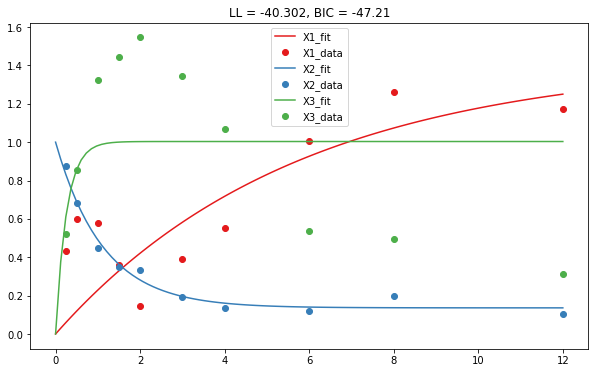

In [16]:
# b)
M_diag = np.eye(3)
M_diag
theta_ML1 = fit_model(M_diag)
plot_fit(M_diag, theta_ML1)

`ftol` termination condition is satisfied.


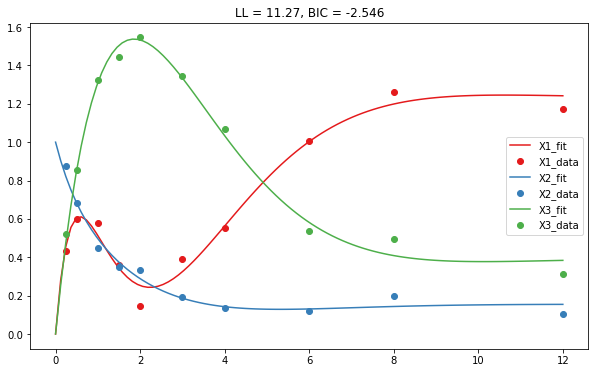

In [17]:
M_full = np.full((3,3),1)
M_full
theta_ML2 = fit_model(M_full)
plot_fit(M_full, theta_ML2)

`ftol` termination condition is satisfied.


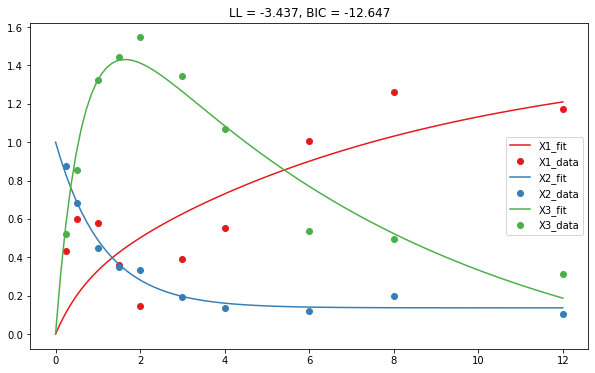

In [18]:
M_cross = np.array([[1,0,1],[0,1,0],[1,0,1]])
M_cross
theta_ML3 = fit_model(M_cross)
plot_fit(M_cross, theta_ML3)

`ftol` termination condition is satisfied.


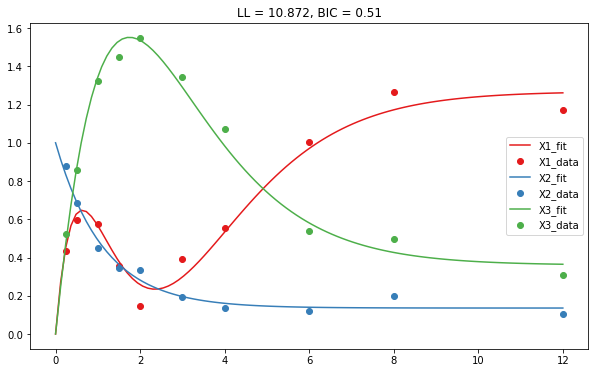

In [19]:
M_test = np.array([[1,0,1],[0,1,0],[1,1,1]])
M_test
theta_ML4 = fit_model(M_test)
plot_fit(M_test, theta_ML4)

The model number 4 (M_test) seems to be the best fit to the data, and its BIC score is the highest. Therefore model 4 can be considered the best model.

In model 4 X1 regulates X3 and vice versa, and X2 regulates also X3.

I tried to find better models could not really find models with higher BIC. It is also important to not overfit the models.